In [1]:
%matplotlib inline

import copy
import numpy as np
import pylab as pl

from astropy import constants as const
import astropy.units as u
from astropy.cosmology import FlatwCDM
cosmo = FlatwCDM(H0=71, Om0=0.264, Ob0=0.044792699861138666, w0=-1.000000)

vc = const.c.to(u.km/u.second) # km/s
apr =  u.rad.to(u.arcsecond) # 1.0/np.pi*180.*3600        # 1/1^{''}

In [2]:
def make_r_coor(bs,nc):
    ds = bs/nc
    xx01 = np.linspace(-bs/2.0,bs/2.0-ds,nc)+0.5*ds
    xx02 = np.linspace(-bs/2.0,bs/2.0-ds,nc)+0.5*ds
    xg1,xg2 = np.meshgrid(xx01,xx02)
    return xg1,xg2

In [3]:
class StrongLensingSim(object):
    def __init__(self, xg1, xg2, lensCat, srcsCat, cosmology=cosmo):
        # meshgrids
        self.xg1 = xg1
        self.xg2 = xg2      
        # cosmological model
        self.cosmology = cosmology
        self.lensCat = copy.deepcopy(lensCat)
        self.srcsCat = copy.deepcopy(srcsCat)
        # lensing simulation
        self.create_lens_model()
        self.ray_shooting()
        self.generate_lensed_sersic()
        self.add_noise() # where you do modeling, you do not need to include this step
        
    def create_lens_model(self):
        # create mass model of lens and calculate deflection angles
        Das = self.cosmology.angular_diameter_distance(self.srcsCat['ZSRC']).value
        Dals= self.cosmology.angular_diameter_distance_z1z2(self.lensCat['ZLENS'], self.srcsCat['ZSRC']).value
        self.lensCat['REIN'] = 4.0*np.pi*(self.lensCat['VELDISP']/vc.value)**2.0*Dals/Das*apr        
        sx = self.xg1 - self.lensCat['XLENS']
        sy = self.xg2 - self.lensCat['YLENS']
        cs = np.cos(self.lensCat['PHIE'])
        sn = np.sin(self.lensCat['PHIE'])
        sx_r =  sx * cs + sy * sn
        sy_r = -sx * sn + sy * cs
        ql = 1.0-self.lensCat['ELLIP']
        fq = 1.0/(np.sqrt((1.+ql**2)/(2. * ql)))*np.sqrt((1 + ql**2)/2)
        reScale = self.lensCat['REIN']*fq
        rcScale = self.lensCat['RCORE']*np.sqrt((1 + ql**2) / (2*ql**2))
        psi = np.sqrt(ql**2.0*(rcScale**2.0+sx_r**2.0)+sy_r**2.0)
        if ql==1.0:
            dx_r = reScale*sx_r/(psi+rcScale)
            dy_r = reScale*sy_r/(psi+rcScale)
        else:
            dx_r = (reScale/np.sqrt((1.0-ql**2.0)))*np.arctan(np.sqrt((1.0-ql**2.0))*sx_r/(psi + rcScale))
            dy_r = (reScale/np.sqrt((1.0-ql**2.0)))*np.arctanh(np.sqrt((1.0-ql**2.0))*sy_r/(psi + rcScale*ql**2.0))
        # primary lens
        dx = dx_r * cs - dy_r * sn
        dy = dx_r * sn + dy_r * cs
        # external shear
        tr2 = self.lensCat['PHIG']
        cs2 = np.cos(2.0 * tr2)
        sn2 = np.sin(2.0 * tr2)
        dx2 = self.lensCat['GAMMA'] * (cs2 * sx + sn2 * sy)
        dy2 = self.lensCat['GAMMA'] * (sn2 * sx - cs2 * sy)
        # external kappa
        dx3 = self.lensCat['EXTKAPPA'] * sx
        dy3 = self.lensCat['EXTKAPPA'] * sy
        # total
        self.alpha1 = dx + dx2 + dx3
        self.alpha2 = dy + dy2 + dy3
        
    def ray_shooting(self):
        # shooting light rays from lens plane to source plane
        self.yg1 = self.xg1 - self.alpha1
        self.yg2 = self.xg2 - self.alpha2
        
    def generate_lensed_sersic(self):
        # generate lensed images of a source modeled by Sersic profile
        bn = 2.0*self.srcsCat['SINDEX']-1/3.0+0.009876/self.srcsCat['SINDEX']
        xi1new = (self.yg1-self.srcsCat['XSRC'])*np.cos(self.srcsCat['PHIS'])+(self.yg2-self.srcsCat['YSRC'])*np.sin(self.srcsCat['PHIS'])
        xi2new = (self.yg2-self.srcsCat['YSRC'])*np.cos(self.srcsCat['PHIS'])-(self.yg1-self.srcsCat['XSRC'])*np.sin(self.srcsCat['PHIS'])
        R_scale = np.sqrt((xi1new/self.srcsCat['ASRC'])**2+(xi2new/self.srcsCat['BSRC'])**2)
        R_scale_th = 0.01
        R_scale[R_scale<R_scale_th] = R_scale_th
        img = np.exp(-bn*((R_scale)**(1.0/self.srcsCat['SINDEX'])-1.0))
        self.lensed_images = img/np.exp(-bn*((R_scale_th)**(1.0/self.srcsCat['SINDEX'])-1.0))
        
    def add_noise(self):
        # add noise to the clean simulated images
        nx, ny = np.shape(self.lensed_images)
        mu, sigma = 0, np.max(self.lensed_images)*0.1
        noise_map = np.random.normal(mu, sigma, (nx, ny))
        self.lensed_images += noise_map
        
    def visualize_lensed_images(self):
        # visualize the output
        pl.figure(figsize=(8, 8))
        pl.imshow(self.lensed_images)

[[ 0.03968178  0.00566153 -0.03001391 ...  0.0729251  -0.08149769
  -0.04226893]
 [-0.00745952 -0.11734036 -0.03791086 ... -0.06477457 -0.02232036
   0.01466244]
 [-0.0535409   0.00092921 -0.00042431 ...  0.02881475 -0.00524536
  -0.14317893]
 ...
 [ 0.17867643 -0.04157852 -0.01938333 ... -0.15112624 -0.01358779
   0.07403915]
 [-0.00872529 -0.05303784  0.19165101 ...  0.0174348  -0.01785994
   0.13205683]
 [-0.07991921  0.06426362 -0.03794304 ... -0.0883128   0.07972073
  -0.08411143]]


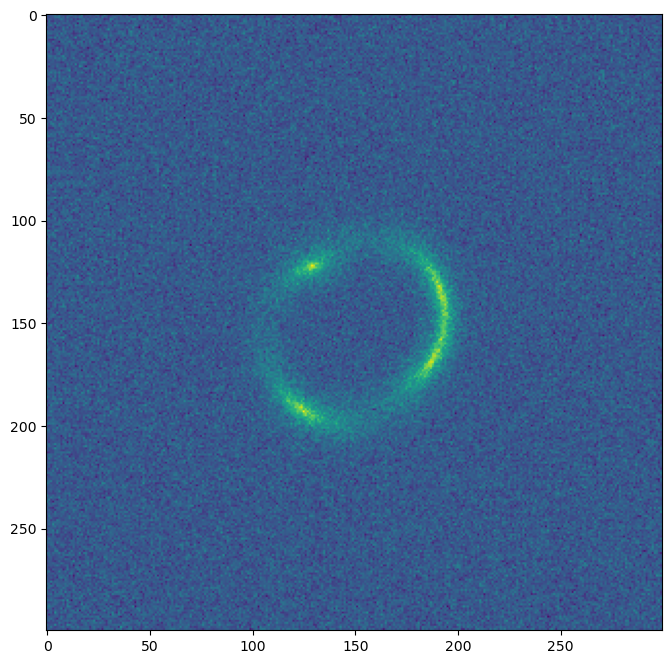

In [4]:
# lens parameters
lensCat_a = {}
lensCat_a['LENSID']  = 0
lensCat_a['VELDISP'] = 320.0 # velocity dispersion of the lens, km/s
lensCat_a['XLENS']   = 0.0   # angular position of the lens, arcsec
lensCat_a['YLENS']   = 0.0   # angular position of the lens, arcsec
lensCat_a['ZLENS']   = 0.5   # redshift of the lens
lensCat_a['ELLIP']   = 0.3   # ellipticity of the lens
lensCat_a['PHIE']    = 37/180*np.pi # position angule of the lens, rad
lensCat_a['RCORE']   = 0.0   # core size of the lens, arcsec
lensCat_a['GAMMA']   = 0.05  # external shear
lensCat_a['PHIG']    =-28/180*np.pi # position angle of the external shear, rad
lensCat_a['EXTKAPPA']= 0.0   # external convergence 

# source parameters
srcsCat_a = {}
srcsCat_a['ZSRC']    = 1.0   # redshift of the source
srcsCat_a['XSRC']    = 0.03  # angular position of the source, arcsec
srcsCat_a['YSRC']    = 0.15  # angular position of the source, arcsec
srcsCat_a['ASRC']    = 0.3   # major axis of the effective radius of the source, arcsec
srcsCat_a['BSRC']    = 0.2   # minor axis of the effective radius of the source, arcsec
srcsCat_a['PHIS']    = 77/180.*np.pi # position angle of the source, rad
srcsCat_a['SINDEX']  = 1.1 

# meshgrids
dsx = 0.03    # pixel size
nnn = 300     # number of pixels perside of the box
bsz = dsx*nnn # box size of the field of view
xi1, xi2 = make_r_coor(bsz, nnn)

test_a = StrongLensingSim(xi1, xi2, lensCat_a, srcsCat_a)

print(test_a.lensed_images)
test_a.visualize_lensed_images()

In [5]:
from scipy.optimize import curve_fit

# # complete the code below
# popt, pcov = curve_fit(rho_NFW, rb, yb)#, sigma=eb)

# print(popt)

# pl.figure(figsize=(12, 8))
# pl.plot(rb, yb, 'C0.') 
# pl.plot(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
# pl.plot(rb, rho_NFW(rb, *popt), 'C2-',
#          label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
# pl.xlim(0.01, R_max_0)
# pl.ylim(1e-3, 1e3)
# pl.legend()

/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)


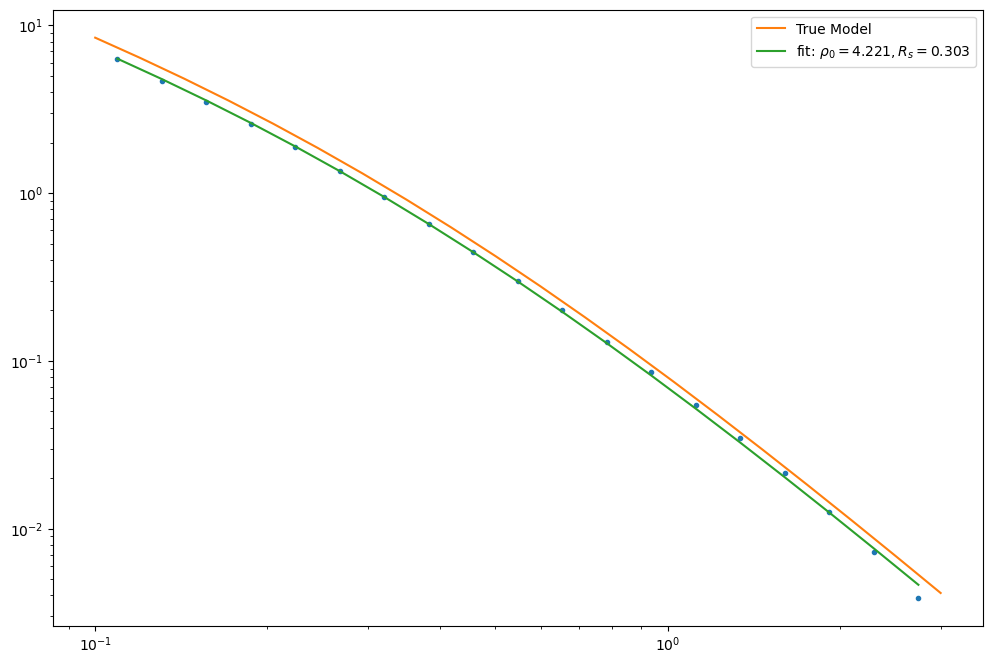

In [9]:
from scipy.optimize import curve_fit

def log_rho_NFW(log_r, rho_0, R_s):
    r = 10**log_r
    # define rho_NFW in logarithm space
    res = rho_0/((r/R_s)*(1 + r/R_s)**2)
    return np.log10(res)

log_rb_arr = np.log10(rb_arr)
log_yb_arr = np.log10(yb_arr)
log_eb_arr = np.log10(eb_arr)/50.0

idx_inf = np.isinf(log_yb_arr) # remove infs, think of how to remove NaNs?
popt, pcov = curve_fit(log_rho_NFW, log_rb_arr[~idx_inf], log_yb_arr[~idx_inf])#, sigma=eb)

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'C0.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
pl.loglog(rb, rho_NFW(rb, *popt), 'C2-',
         label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
pl.legend()

## 2.2 Fit to NFW mass model

In [10]:
# nbins = 100
# rbins = np.linspace(1e-2, R_max_0, nbins)

# rb = []
# yb = []
# eb = []
# for i in range(nbins-1):
#     idx = rt<rbins[i+1]
#     rb_tmp = rbins[i+1]
#     # how to calculate yb_tmp here?
#     yb_tmp = len(rt[idx])*mPrtcls
#     rb.append(rb_tmp)
#     yb.append(yb_tmp)
#     eb.append(np.sqrt(len(rt[idx])/nPrtcls)/10)
    
# rb_arr = np.array(rb)
# yb_arr = np.array(yb)
# eb_arr = np.array(eb)


# pl.figure(figsize=(12, 8))
# pl.loglog(rb, yb, 'r.') 
# pl.loglog(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), '-')

In [11]:
# from scipy.optimize import curve_fit

# # complete the code below
# popt, pcov = curve_fit(mass_rmax_NFW, rb, yb) #, sigma=eb)

# print(popt)
# print(pcov)

# pl.figure(figsize=(12, 8))
# pl.loglog(rb, yb, 'C0.') 
# pl.loglog(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
# pl.loglog(rb, mass_rmax_NFW(rb, *popt), 'C2-',
#          label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
# pl.legend()

/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)
/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)
/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)
/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)


Maximum likelihood estimates:
Rho_0 = 5.007
R_s = 0.337
4.89498059070405 0.3181854673436006
5.0 0.3


ValueError: 'yerr' must not contain negative values

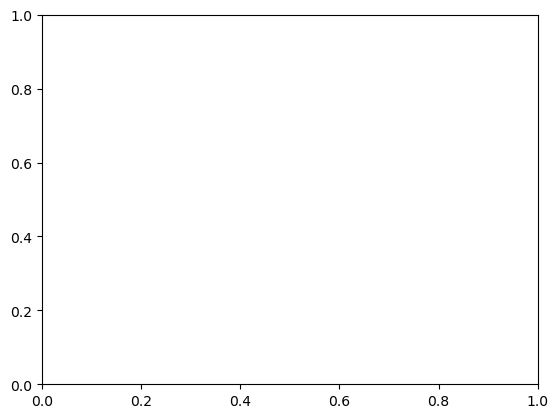

In [12]:
from scipy.optimize import minimize

def least_square(theta, x, y, yerr):
    rho_0_f, R_s_f = theta
    # model = mass_rmax_NFW(x, rho_0_f, R_s_f)
    # model = rho_NFW(x, rho_0_f, R_s_f)
    model = log_rho_NFW(x, rho_0_f, R_s_f)
    sigma = yerr ** 2
    return np.sum((y - model) ** 2 / sigma)

nll = lambda *args: least_square(*args)
initial = np.array([rho_0_0, R_s_0]) + 0.1 * np.random.randn(2)
soln_ls = minimize(nll, initial, args=(log_rb_arr, log_yb_arr, log_eb_arr))
rho_0_ls, R_s_ls = soln_ls.x

def log_likelihood(theta, x, y, yerr):
    rho_0_f, R_s_f  = theta
    # model = mass_rmax_NFW(x, rho_0_f, R_s_f)
    # model = rho_NFW(x, rho_0_f, R_s_f)
    model = log_rho_NFW(x, rho_0_f, R_s_f)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#max log_likelihood
nll = lambda *args: -log_likelihood(*args)
initial = np.array([rho_0_0, R_s_0]) + 0.1 * np.random.randn(2)
soln_ml = minimize(nll, initial, args=(log_rb_arr, log_yb_arr, log_eb_arr))
rho_0_ml, R_s_ml = soln_ml.x

print("Maximum likelihood estimates:")
print("Rho_0 = {0:.3f}".format(rho_0_ml))
print("R_s = {0:.3f}".format(R_s_ml))

print(rho_0_ls, R_s_ls)
print(rho_0_0, R_s_0)


#make the plot
pl.errorbar(log_rb_arr, log_yb_arr, yerr=log_eb_arr, fmt=".b", capsize=0)
# pl.plot(np.log10(rb_arr), np.log10(mass_rmax_NFW(rb_arr, rho_0_0, R_s_0)), "k-", alpha=0.3, lw=5, label="truth")
pl.plot(log_rb_arr, log_rho_NFW(log_rb_arr, rho_0_0, R_s_0), "k-", alpha=0.3, lw=5, label="truth")
# pl.plot(rb_arr, np.dot(np.vander(rb_arr, 2), [rho_0_ls, R_s_ls]), "--k", label="LS")
# pl.plot(rb_arr, np.dot(np.vander(rb_arr, 2), [rho_0_ml, R_s_ml]), ":k", label="ML")
pl.legend(fontsize=14)
pl.xlim(-3, 2)
pl.xlabel("x")
pl.ylabel("y");

In [13]:
def log_prior(theta):
    rho_0_f, R_s = theta
    if 3 < rho_0_f < 7 and 0.1 < R_s < 0.5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

nsteps = 5000

pos = soln_ml.x +  0.01*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(log_rb_arr, log_yb_arr, log_eb_arr)
)
sampler.run_mcmc(pos, nsteps, progress=True);

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2381.13it/s]


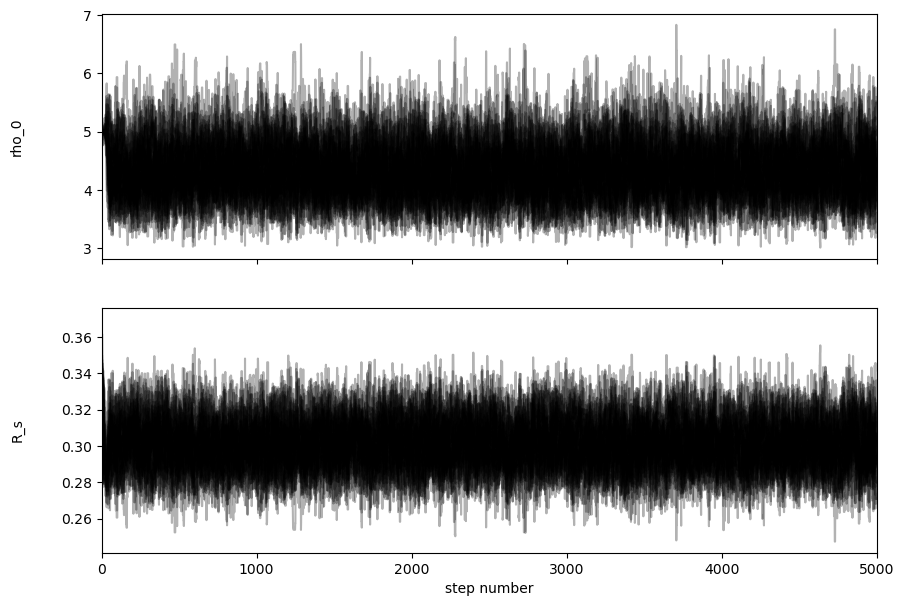

In [14]:
fig, axes = pl.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rho_0", "R_s"]

samples=samples[:, :, :]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[35.57404583 35.08820523]


In [16]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
flat_samples_2 = sampler.get_chain(discard=1000, thin=2, flat=True)
print(samples.shape)
print(flat_samples.shape)
print(flat_samples_2.shape)

(5000, 32, 2)
(8512, 2)
(64000, 2)


2.0441363765709117 2.0446497488412243


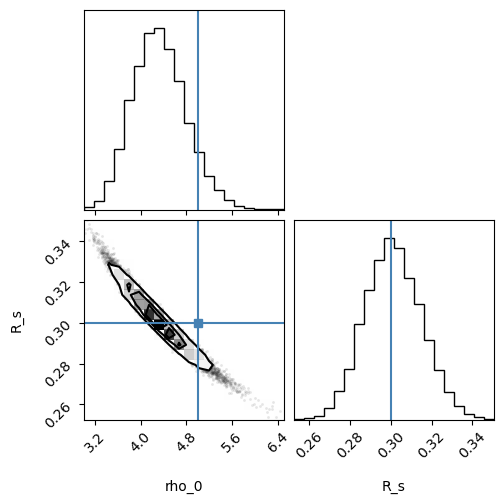

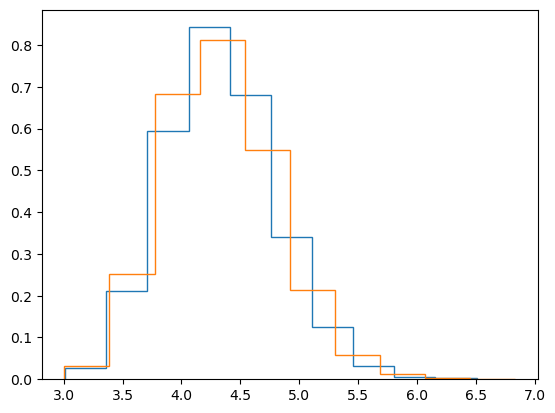

In [17]:
import corner
fig = corner.corner(
    flat_samples, labels=labels, truths=[rho_0_0, R_s_0]
)

pl.figure()
pl.hist(flat_samples[:,0],histtype='step',density=True)
pl.hist(flat_samples_2[:,0],histtype='step',density=True)
print(flat_samples.std(),flat_samples_2.std())